# Nonlinear for systems of ODEs

In [130]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
torch.manual_seed(12)

## Generate training data

In [131]:
def sin(x):
        if isinstance(x, torch.Tensor):
            return torch.sin(x)
        else:
            return np.sin(x)

def cos(x):
        if isinstance(x, torch.Tensor):
            return torch.cos(x)
        else:
            return np.cos(x)

In [132]:
w0 = 3

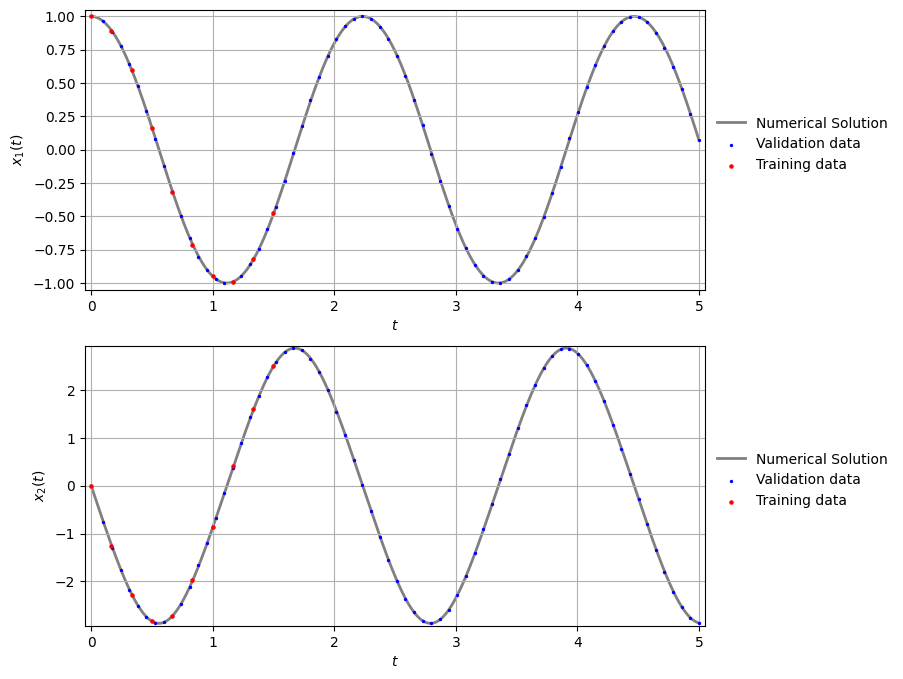

In [133]:
# Parameters and initial conditions
# w0^2 = g/L,

X0 = [1, 0]
E0 = 0.5*X0[1]**2 + (w0**2)*np.cos(X0[0])

# time domain
ti = 0
tf = 5
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

def f1(x1, x2, t):
    return x2

def f2(x1, x2, t):
    return -(w0**2)*sin(x1)

def E(x1, x2):
    return 0.5*x2**2 + (w0**2)*np.cos(X0[0])

# Numerical Solution
def ODE(X, t):
    dXdt = [f1(X[0], X[1], t), f2(X[0], X[1], t)]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 10
Noise_mean = 1
Noise_std  = 0
Noise      = torch.randn((N_training,2))*Noise_std + Noise_mean
t_data  = torch.linspace(ti, tf*0.3, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]*Noise
x1_data = training_data[:,0].view(-1,1)
x2_data = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 70
t_val  = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val = validation_data[:,0].view(-1,1)
x2_val = validation_data[:,1].view(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(t, x1, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[0].scatter(t_val, x1_val, color="blue", label="Validation data", s=2, zorder=2)
axes[0].scatter(t_data, x1_data, color="red", label="Training data", s=5, zorder=3)
axes[0].set_xlim(ti-.05, tf+0.05)
axes[0].set_ylim(-x1_max-.05, x1_max+0.05)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x_1(t)$')
axes[0].legend(frameon=False, loc=(1.01, 0.40))
axes[0].grid()

axes[1].plot(t, x2, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[1].scatter(t_val, x2_val, color="blue", label="Validation data", s=2, zorder=2)
axes[1].scatter(t_data, x2_data, color="red", label="Training data", s=5, zorder=3)
axes[1].set_xlim(ti-.05, tf+0.05)
axes[1].set_ylim(-x2_max-.05, x2_max+0.05)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x_2(t)$')
axes[1].legend(frameon=False, loc=(1.01, 0.40))
axes[1].grid()

plt.show()

## PINN

In [134]:
def make_plot(
    i, loss_val, epochs,
    t, t_data, t_validation, t_collocation,
    solution_1, prediction_1,
    solution_2, prediction_2,
    data_1, data_2,
    validation_1, validation_2,
    x1_max, x2_max,
    training_loss, validation_loss
    
):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    fig.suptitle(f"Training Step {i} \n Validation Loss: {loss_val.item():.4f}", fontsize=16)

    axes[0,0].plot(t, solution_1, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[0,0].plot(t, prediction_1, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[0,0].scatter(t_data, data_1, color="red", label="Training data", s=5, zorder=3)
    axes[0,0].scatter(t_validation, validation_1, color="blue", label="Validation data", s=2, zorder=2)
    axes[0,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[0,0].set_xlim(ti-.05, tf+0.05)
    axes[0,0].set_ylim(-x1_max-.05, x1_max+0.05)
    axes[0,0].set_xlabel('$t$')
    axes[0,0].set_ylabel('$x_1(t)$')
    axes[0,0].legend(frameon=False, loc=(1.01, 0.48))
    axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[0,0].grid()

    axes[1,0].plot(t, solution_2, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[1,0].scatter(t_validation, validation_2, color="blue", label="Validation data", s=2, zorder=2)
    axes[1,0].scatter(t_data, data_2, color="red", label="Training data", s=5, zorder=3)
    axes[1,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[1,0].plot(t, prediction_2, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[1,0].set_xlim(ti-.05, tf+0.05)
    axes[1,0].set_ylim(-x2_max-.05, x2_max+0.05)
    axes[1,0].set_xlabel('$t$')
    axes[1,0].set_ylabel('$x_2(t)$')
    axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[1,0].grid()
    
    axes[0,1].plot(np.arange(i+1), training_loss, label="Training Loss", color='red', lw=1)
    axes[0,1].plot(np.arange(i+1), validation_loss, label="validation Loss", color='blue', lw=1)
    axes[0,1].set_xlabel('Training Steps')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].set_xlim(0, epochs)
    axes[0,1].set_ylim(1e-6, 1e2)
    axes[0,1].set_yscale('log')
    axes[0,1].grid()
    axes[0,1].legend(frameon=False, loc=(0.7, 1))
    
    
    X_max = max(x1_max, x2_max)
    axes[1,1].plot(t, torch.abs((solution_1 - prediction_1)), label="Error in $x_1$", color='red', lw=1)
    axes[1,1].plot(t, torch.abs((solution_2 - prediction_2)), label="Error in $x_2$", color='blue', lw=1)
    axes[1,1].set_xlabel('t')
    axes[1,1].set_ylabel('relative error')
    axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axes[1,1].set_ylim(1e-6, 1e4)
    axes[1,1].set_yscale('log')
    axes[1,1].grid()
    axes[1,1].legend(frameon=False, loc=(0.7, 1))
    
    plt.tight_layout()

In [135]:
# Define Neural Network Structure

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self):
        super().__init__()
        self.scale = lambda T : (T - ti)/(tf-ti)
        
        self.fcs = nn.Sequential(*[nn.Linear(1, 32), nn.Tanh()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()])
                    ])
        self.fce = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [136]:
# Define the sample locations for physics loss
N_phys = 50
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

Training step 0
x1 MSE = 5.2410e-01, x2 MSE = 3.7273e+00
Total Training Loss = 6.1691e+00, 
ODE Training Loss = 24.8847%, Data Training Loss = 68.9140%, Derivative Training Loss = 6.2013%, Energy Training Loss = 0.0000% 

x1 MSE = 5.1825e-01, x2 MSE = 4.1070e+00
Total Validation Loss = 4.9793e+00, 
ODE Validation Loss = 7.1089%, Data Validation Loss = 92.8911%
----------------------------------------------


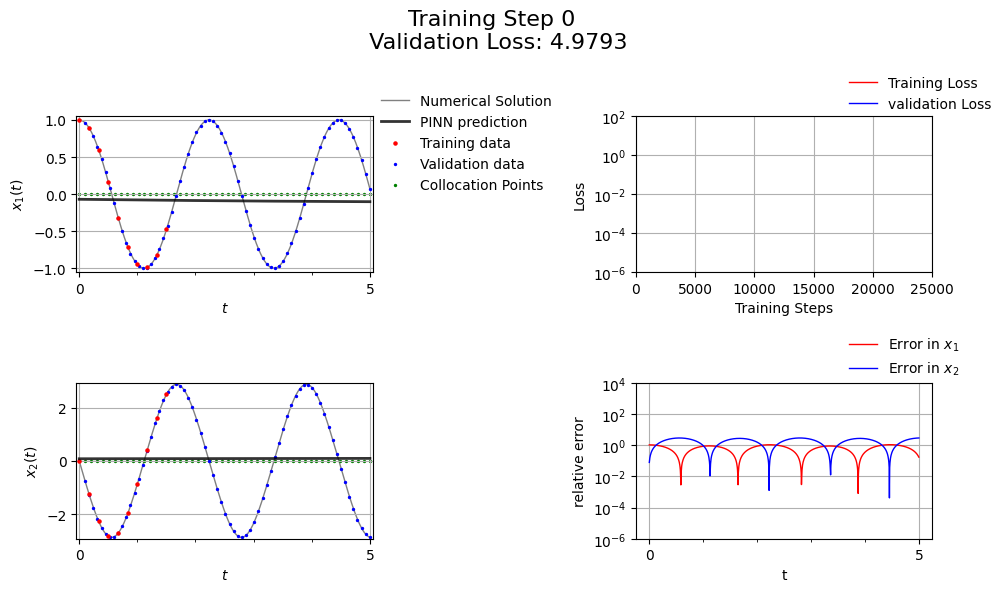

Training step 1000
x1 MSE = 4.3194e-03, x2 MSE = 1.0804e-02
Total Training Loss = 1.6141e-01, 
ODE Training Loss = 88.8190%, Data Training Loss = 9.3697%, Derivative Training Loss = 1.8073%, Energy Training Loss = 0.0040% 

x1 MSE = 2.4002e-01, x2 MSE = 1.9415e+00
Total Validation Loss = 2.3504e+00, 
ODE Validation Loss = 7.1878%, Data Validation Loss = 92.8121%
----------------------------------------------
Training step 2000
x1 MSE = 8.6687e-04, x2 MSE = 2.2902e-03
Total Training Loss = 6.7684e-02, 
ODE Training Loss = 94.4533%, Data Training Loss = 4.6644%, Derivative Training Loss = 0.8712%, Energy Training Loss = 0.0112% 

x1 MSE = 8.7124e-02, x2 MSE = 6.2494e-01
Total Validation Loss = 7.6868e-01, 
ODE Validation Loss = 7.3660%, Data Validation Loss = 92.6337%
----------------------------------------------
Training step 3000
x1 MSE = 4.4789e-05, x2 MSE = 6.0828e-04
Total Training Loss = 3.5495e-02, 
ODE Training Loss = 97.9890%, Data Training Loss = 1.8399%, Derivative Training L

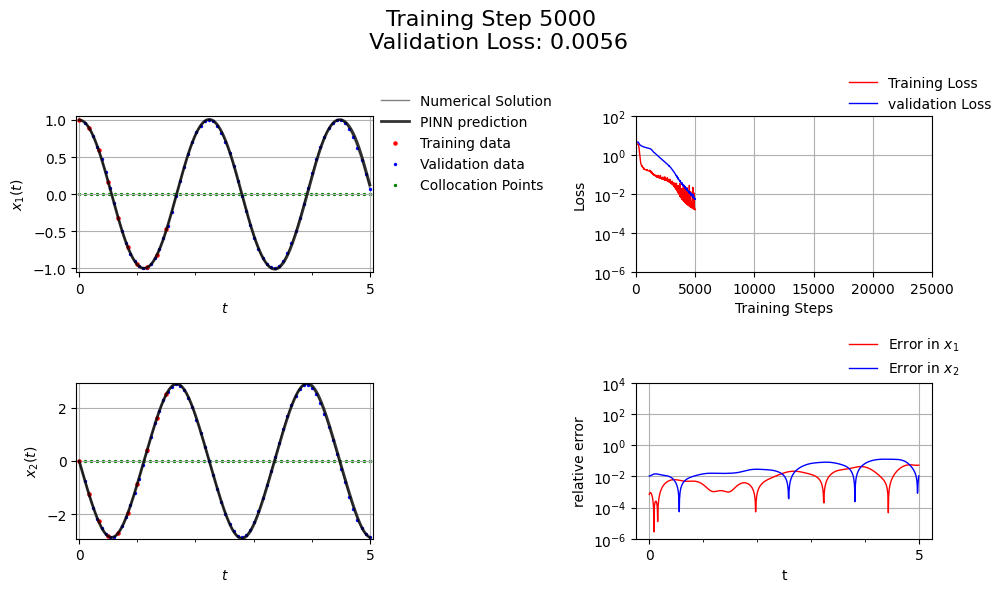

Training step 6000
x1 MSE = 2.4886e-05, x2 MSE = 8.3809e-04
Total Training Loss = 1.7469e-02, 
ODE Training Loss = 94.9093%, Data Training Loss = 4.9400%, Derivative Training Loss = 0.0841%, Energy Training Loss = 0.0666% 

x1 MSE = 3.2845e-04, x2 MSE = 1.3861e-03
Total Validation Loss = 1.8278e-03, 
ODE Validation Loss = 5.8514%, Data Validation Loss = 93.8025%
----------------------------------------------
Training step 7000
x1 MSE = 7.7174e-06, x2 MSE = 6.5236e-05
Total Training Loss = 5.7763e-04, 
ODE Training Loss = 84.1109%, Data Training Loss = 12.6298%, Derivative Training Loss = 1.2749%, Energy Training Loss = 1.9844% 

x1 MSE = 7.5755e-05, x2 MSE = 6.2612e-04
Total Validation Loss = 7.6339e-04, 
ODE Validation Loss = 7.2322%, Data Validation Loss = 91.9413%
----------------------------------------------
Training step 8000
x1 MSE = 7.2282e-06, x2 MSE = 6.4205e-05
Total Training Loss = 4.4028e-04, 
ODE Training Loss = 79.6099%, Data Training Loss = 16.2247%, Derivative Training

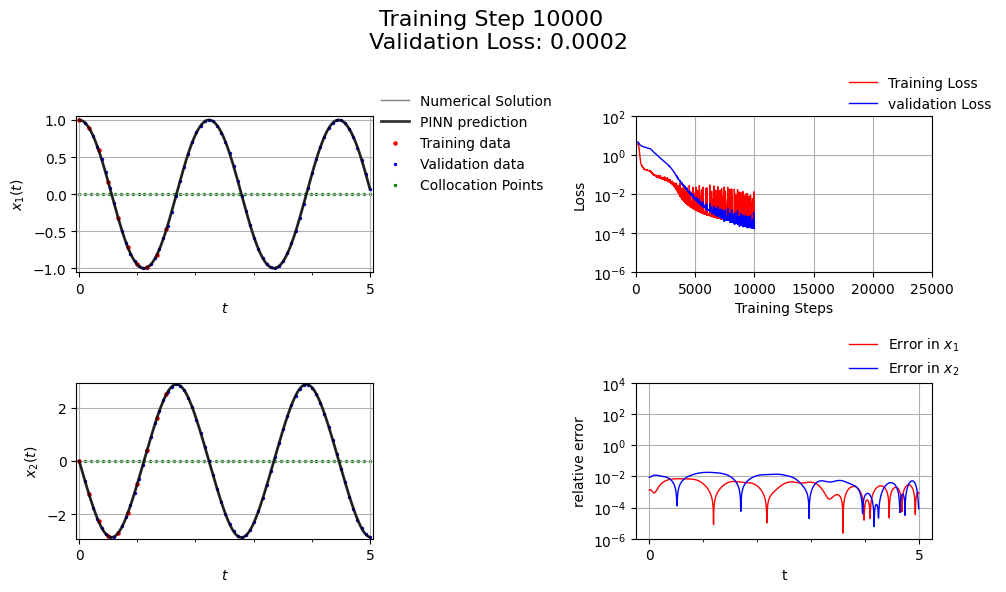

Training step 11000
x1 MSE = 6.5862e-06, x2 MSE = 6.3950e-05
Total Training Loss = 2.4222e-04, 
ODE Training Loss = 63.7475%, Data Training Loss = 29.1210%, Derivative Training Loss = 2.4174%, Energy Training Loss = 4.7141% 

x1 MSE = 1.3538e-05, x2 MSE = 1.1818e-04
Total Validation Loss = 1.4888e-04, 
ODE Validation Loss = 7.3132%, Data Validation Loss = 88.4778%
----------------------------------------------
Training step 12000
x1 MSE = 7.2678e-06, x2 MSE = 1.1791e-04
Total Training Loss = 8.6357e-04, 
ODE Training Loss = 83.4964%, Data Training Loss = 14.4953%, Derivative Training Loss = 0.6820%, Energy Training Loss = 1.3264% 

x1 MSE = 2.2524e-05, x2 MSE = 1.2745e-04
Total Validation Loss = 1.6632e-04, 
ODE Validation Loss = 6.0582%, Data Validation Loss = 90.1715%
----------------------------------------------
Training step 13000
x1 MSE = 6.4180e-06, x2 MSE = 6.3101e-05
Total Training Loss = 1.9022e-04, 
ODE Training Loss = 54.5911%, Data Training Loss = 36.5461%, Derivative Trai

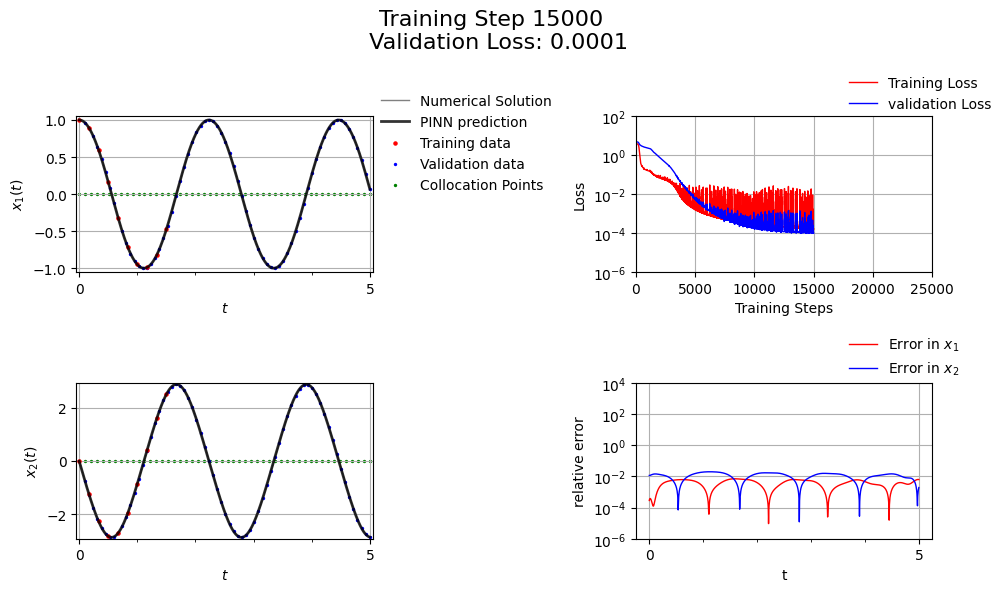

Training step 16000
x1 MSE = 6.5318e-06, x2 MSE = 6.2479e-05
Total Training Loss = 1.5369e-04, 
ODE Training Loss = 44.3752%, Data Training Loss = 44.9015%, Derivative Training Loss = 3.3077%, Energy Training Loss = 7.4156% 

x1 MSE = 9.1136e-06, x2 MSE = 7.3202e-05
Total Validation Loss = 9.5976e-05, 
ODE Validation Loss = 7.7243%, Data Validation Loss = 85.7678%
----------------------------------------------
Training step 17000
x1 MSE = 6.1916e-06, x2 MSE = 6.2390e-05
Total Training Loss = 1.3959e-04, 
ODE Training Loss = 39.2502%, Data Training Loss = 49.1316%, Derivative Training Loss = 3.4516%, Energy Training Loss = 8.1666% 

x1 MSE = 9.0277e-06, x2 MSE = 7.2676e-05
Total Validation Loss = 9.5127e-05, 
ODE Validation Loss = 7.5405%, Data Validation Loss = 85.8885%
----------------------------------------------
Training step 18000
x1 MSE = 6.0869e-06, x2 MSE = 6.2922e-05
Total Training Loss = 1.3437e-04, 
ODE Training Loss = 36.7209%, Data Training Loss = 51.3569%, Derivative Trai

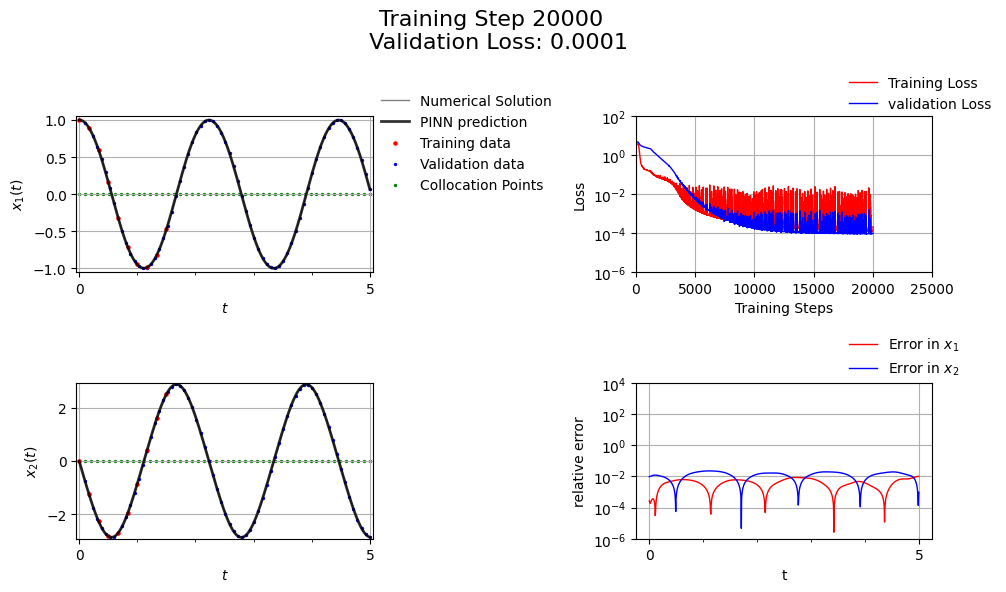

Training step 21000
x1 MSE = 7.1689e-06, x2 MSE = 6.7044e-05
Total Training Loss = 1.7324e-04, 
ODE Training Loss = 47.6864%, Data Training Loss = 42.8381%, Derivative Training Loss = 2.8920%, Energy Training Loss = 6.5835% 

x1 MSE = 9.2879e-06, x2 MSE = 7.8348e-05
Total Validation Loss = 1.0092e-04, 
ODE Validation Loss = 6.9678%, Data Validation Loss = 86.8367%
----------------------------------------------
Training step 22000
x1 MSE = 5.9899e-06, x2 MSE = 6.1900e-05
Total Training Loss = 1.1475e-04, 
ODE Training Loss = 27.1677%, Data Training Loss = 59.1638%, Derivative Training Loss = 3.7370%, Energy Training Loss = 9.9315% 

x1 MSE = 8.9259e-06, x2 MSE = 6.9377e-05
Total Validation Loss = 9.1464e-05, 
ODE Validation Loss = 7.5577%, Data Validation Loss = 85.6102%
----------------------------------------------
Training step 23000
x1 MSE = 6.6655e-06, x2 MSE = 6.4701e-05
Total Training Loss = 2.0216e-04, 
ODE Training Loss = 56.8241%, Data Training Loss = 35.3018%, Derivative Trai

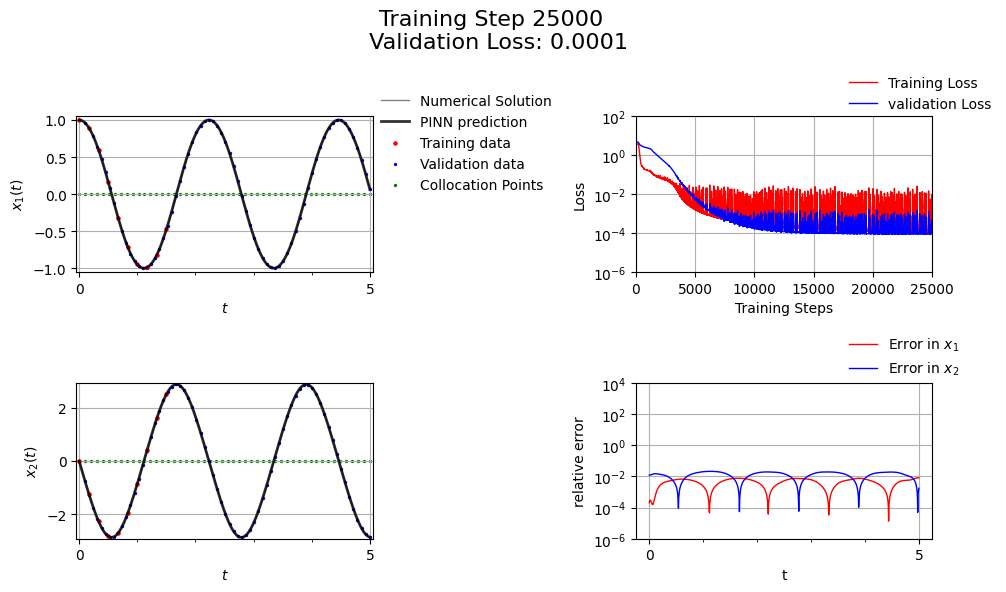

In [137]:
# PINN
torch.manual_seed(123)

# Define PINN model. 1 input, 1 output, 3 hidden layers of 32 nodes.
PINN = FCN()

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-3)

# Exponential scheduler, multiplies learning rate (lr) by gamma every 2000 epochs; set gamma to 1 to disable
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# Number of training steps
epochs = 25_000 + 1

# Weights for loss function
wd, wp, we  = 1e-2, 1e0, 1e-6  

# stores loss values
training_loss, validation_loss = [], []
physics_losses, data_losses, derivative_losses, energy_losses = [], [], [], []
MSE_1 = []
MSE_2 = []

torch.autograd.set_detect_anomaly(False)
for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for position
    U  = PINN(t_training)
    u1 = U[:,0].view(-1,1)
    u2 = U[:,1].view(-1,1)
    data_loss = ((u1 - x1_data)**2 + (u2 - x2_data)**2).mean()
    
    du1 = torch.autograd.grad(u1, t_training, torch.ones_like(u1), create_graph=True, retain_graph=True)[0]
    du2 = torch.autograd.grad(u2, t_training, torch.ones_like(u2), create_graph=True, retain_graph=True)[0]
    derivative_loss = ((du1 - f1(x1_data, x2_data, t_training))**2 + (du2 - f2(x1_data, x2_data, t_training))**2).mean()
    
    E_loss = ((E(u1, u2) - E0)**2).mean()
    
    # Compute the ODE loss
    V   = PINN(t_physics)
    v1  = V[:,0].view(-1,1)
    v2  = V[:,1].view(-1,1)
    dv1 = torch.autograd.grad(v1, t_physics, torch.ones_like(v1), create_graph=True)[0]
    dv2 = torch.autograd.grad(v2, t_physics, torch.ones_like(v2), create_graph=True)[0]
    loss_ODE = ((dv1 - f1(v1, v2, t_physics))**2 + (dv2 - f2(v1,v2,t_physics))**2).mean()
    E_loss_col = ((E(v1, v2) - E0)**2).mean()
    
    energy_loss = E_loss + E_loss_col
    
    # Compute total loss
    loss = data_loss + wd*derivative_loss + wp*loss_ODE + we*energy_loss
    
    training_loss.append(loss.item())
    physics_losses.append(loss_ODE.item())
    data_losses.append(data_loss.item())
    derivative_losses.append(derivative_loss.item())
    energy_losses.append(energy_loss.item())
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    
    # every 1000 epochs, multiply learning rate by gamma
    if (i+1) % 1000 == 0: scheduler.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    U_val = PINN(t_validation)
    u1_val = U_val[:,0].view(-1,1)
    u2_val = U_val[:,1].view(-1,1)
    mse1 = torch.mean((u1_val - x1_val)**2)
    mse2 = torch.mean((u2_val - x2_val)**2)
    loss_value_val = mse1 + mse2
    loss_energy_val = torch.mean((E(u1_val, u2_val) - E0)**2)
    
    MSE_1.append(mse1.item())
    MSE_2.append(mse2.item())

    du1_val = torch.autograd.grad(u1_val, t_validation, torch.ones_like(u1_val), create_graph=True)[0]
    du2_val = torch.autograd.grad(u2_val,  t_validation, torch.ones_like(u2_val),  create_graph=True)[0]
    loss_ODE_val = torch.mean((du1_val - f1(x1_val, x2_val, t_validation))**2 + (du2_val - f2(x1_val, x2_val, t_validation))**2)
    
    loss_val = loss_value_val + wd*loss_ODE_val + we*loss_energy_val
    validation_loss.append(loss_val.item())
    
    # ===
    # Plotting
    # ===
    
    if (i % 1_000) == 0: 
        P  = PINN(t).detach()
        make_plot(
            i=i, loss_val=loss_val, epochs=epochs,
            t=t, t_data=t_data, t_validation=t_val, t_collocation=t_physics.detach(),
            solution_1=x1, prediction_1=P[:,0],
            solution_2=x2, prediction_2=P[:,1],
            data_1=x1_data, data_2=x2_data,
            validation_1=x1_val, validation_2=x2_val,
            x1_max=x1_max, x2_max=x2_max,
            training_loss=training_loss, validation_loss=validation_loss
        )
        print(f"Training step {i}")
        print(f"x1 MSE = {((u1 - x1_data)**2).mean().item():.4e}, x2 MSE = {((u2 - x2_data)**2).mean().item():.4e}")
        print(f"Total Training Loss = {loss.item():.4e}, \n"+
              f"ODE Training Loss = {wp*loss_ODE.item()/loss * 100:.4f}%, "+
              f"Data Training Loss = {data_loss.item()/loss * 100:.4f}%, "+
              f"Derivative Training Loss = {wd*derivative_loss.item()/loss * 100:.4f}%, "+
              f"Energy Training Loss = {we*energy_loss.item()/loss * 100:.4f}% \n")
        
        print(f"x1 MSE = {((u1_val - x1_val)**2).mean().item():.4e}, x2 MSE = {((u2_val - x2_val)**2).mean().item():.4e}")
        print(f"Total Validation Loss = {loss_val.item():.4e}, \n"+
              f"ODE Validation Loss = {wd*loss_ODE_val.item()/loss_val * 100:.4f}%, "+
              f"Data Validation Loss = {loss_value_val.item()/loss_val * 100:.4f}%")
        print("----------------------------------------------")
        
        if i == (epochs-1):
            # plt.savefig("pinn_ode_solution.png", dpi=300)
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

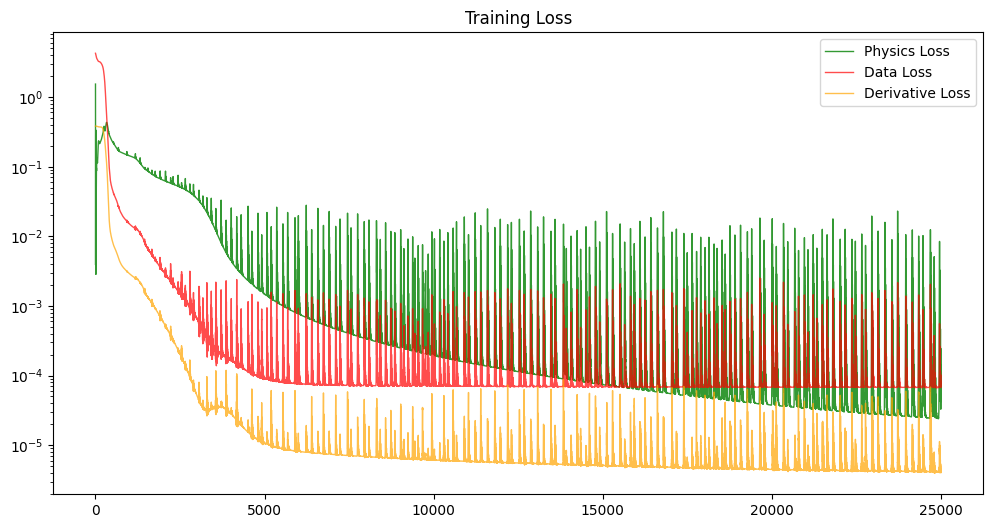

In [138]:
plt.subplots(figsize=(12,6))
plt.plot(np.arange(epochs), physics_losses, label="Physics Loss", color='green', lw=1, alpha=0.8, linestyle = '-')
plt.plot(np.arange(epochs), torch.tensor(data_losses), label="Data Loss", color='red', lw=1, alpha=0.7)
plt.plot(np.arange(epochs), wd*torch.tensor(derivative_losses), label="Derivative Loss", color='orange', lw=1, alpha=0.7)
plt.title("Training Loss")
plt.legend()
plt.yscale('log')
# plt.savefig('loss.png')
plt.show()

In [139]:
PINN_info = torch.stack([
    torch.tensor(training_loss),
    torch.tensor(validation_loss),
    torch.tensor(physics_losses),
    torch.tensor(data_losses),
    torch.tensor(derivative_losses),
    torch.tensor(energy_losses),
    torch.tensor(MSE_1),
    torch.tensor(MSE_2)
], dim=1)

torch.save(PINN_info, f"data/E_Training_info_w0={w0}.pt")